In [1]:
import csv, zipfile, os, sys
import pandas as pd

In [4]:
# Read the CSV file with cleaned metadata (emails) based on the following keywords: influencer, celeb, celebrity, social media, launch, agency, VIP
df = pd.read_csv('data\influencer_metadata.csv')
ids_list = df['id'].tolist()

In [ ]:
print(len(ids_list))

Run to extract OCR text (last column) from zip folder with all CSV files - Extracting CSV is not working on VCL due to limted storage, stops after extracting CSV 286. The code below was run on Google Colab

In [ ]:
def extract_data_from_csvs(zip_file_path, ids_list, output_csv):
    ids_set = set(ids_list)
    csv.field_size_limit(sys.maxsize)

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        with open(output_csv, 'w', newline='', encoding='utf-8') as out_file:
            writer = csv.writer(out_file)
            writer.writerow(['id', 'text'])

            for file_name in z.namelist():
                with z.open(file_name) as csvfile:
                    lines = (line.decode('utf-8').replace('\0', '') for line in csvfile)
                    reader = csv.reader(lines, delimiter='|')
                    for row in reader:
                        if row and row[0] in ids_set:
                            print(f"Processing ID: {row[0]}")
                            writer.writerow([row[0], row[-1]])
extract_data_from_csvs(zip_file_path, ids_list, output_csv)

In [6]:
#Sanity Check 
try:
    csv.field_size_limit(2**20)  # A little over one million characters
except OverflowError:
    print("The specified limit is too large!")

id_count = 0
with open('data\ocr_texts(celeb,celebrity,influencer).csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header
    for row in reader:
        id_count += 1

print(id_count)

18951


In [3]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams, trigrams
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rolando\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rolando\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Dictionary to store OCR texts
ocr_texts = {}

# Path to the CSV file
csv_path = 'data\ocr_texts(celeb,celebrity,influencer).csv'

# Read the OCR text from CSV into the dictionary
with open(csv_path, mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header
    for row in reader:
        doc_id, ocr_text = row
        ocr_texts[doc_id] = ocr_text

# Preprocess each stored OCR text
for doc_id, ocr_text in ocr_texts.items():
    processed_text = preprocess_text(ocr_text)
    ocr_texts[doc_id] = processed_text

In [5]:
print(len(ocr_texts))

18951


Count Vectorizer

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

doc_ids = list(ocr_texts.keys())  # Get all document IDs as a list
documents = list(ocr_texts.values())  # Get all the pre-processed text values as a list

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

doc_term_matrix = vectorizer.fit_transform(documents)

# Convert the matrix to a DataFrame
df = pd.DataFrame(doc_term_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df.insert(0, 'Document ID', doc_ids)

# Save the DataFrame to a CSV file
csv_output_path = 'data\doc_term_matrix.csv'
df.to_csv(csv_output_path, index=False)

In [20]:
print(doc_term_matrix.shape)

(3468, 106489)


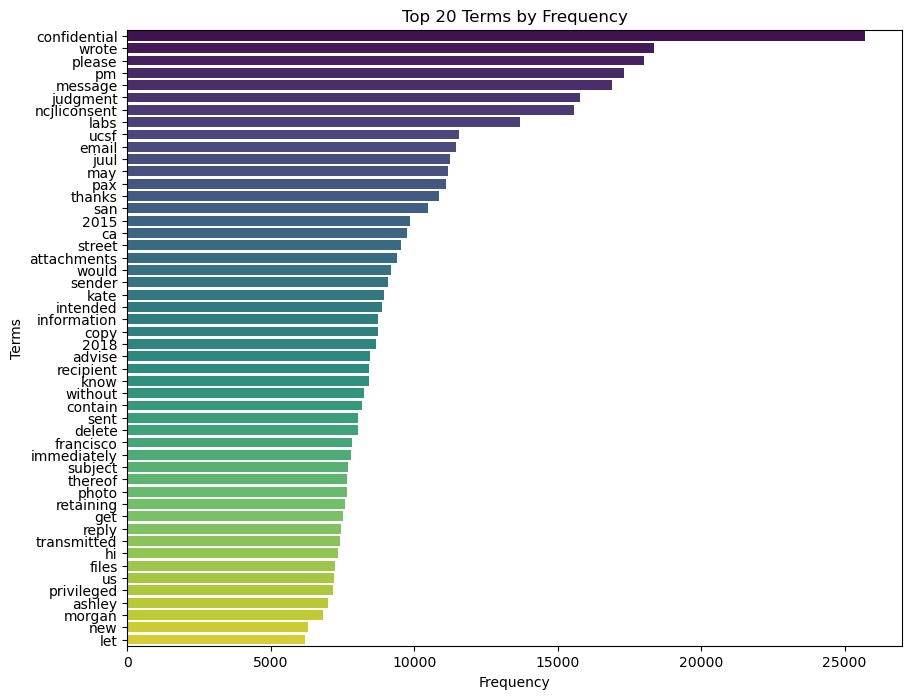

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summing up the occurrences of each term.
term_sums = df.iloc[:, 1:].sum().sort_values(ascending=False).head(50)  # Adjust the number of terms as needed.

# Visualize 
plt.figure(figsize=(10, 8))
sns.barplot(x=term_sums.values, y=term_sums.index, palette='viridis')
plt.title('Top 20 Terms by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Terms')
plt.show()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
doc_ids = list(ocr_texts.keys()) 
documents = list(ocr_texts.values())

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Convert the TF-IDF matrix to a DataFrame
df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df.insert(0, 'Document ID', doc_ids)

# Save the DataFrame to a CSV file
csv_output_path = 'data\ip_tfidf_matrix.csv'
df.to_csv(csv_output_path, index=False)

In [16]:
print(tfidf_matrix.shape)

(3468, 106489)


In [ ]:
# Summing up the TF-IDF occurrences of each term.
term_tfidf_sums = df.sum().sort_values(ascending=False).head(20)  # Adjust the number of terms as needed.

# Visualize
plt.figure(figsize=(10, 8))
sns.barplot(x=term_tfidf_sums.values, y=term_tfidf_sums.index, palette='viridis')
plt.title('Top 20 Terms by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Terms')
plt.show()

Working codes below - not final

Customize stopwords 
1. Most frequent words
2. Words appearing in n% of documents

In [15]:
stop_words = set(stopwords.words('english'))
#custom_stopwords = []
stop_words.update(custom_stopwords)

In [ ]:
stop_words = set(stopwords.words('english'))
print(stop_words)

In [ ]:
# Count the frequency of each word
word_counts = Counter(processed_text.split())
most_common_words = word_counts.most_common(100)  # Get the top 10 most common words

print(most_common_words)

In [ ]:
!pip install wordcloud matplotlib
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Create the word cloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10).generate(processed_text)

# View the word cloud:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [23]:
words = word_tokenize(processed_text)

In [26]:
# Bi-grams
bi_grams = list(bigrams(words))
# Tri-grams
tri_grams = list(trigrams(words))

bi_gram_counts = Counter(bi_grams)
tri_gram_counts = Counter(tri_grams)

In [ ]:
# Print the counts
print("Bi-gram counts:")
for bi_gram, count in bi_gram_counts.items():
    print(f"{bi_gram}: {count}")

In [ ]:
print("\nTri-gram counts:")
for tri_gram, count in tri_gram_counts.items():
    print(f"{tri_gram}: {count}")

In [ ]:
# Top N bi-grams
top_N_bi_grams = bi_gram_counts.most_common(50)

# Print the top 20 bi-grams
print("Top 20 Bi-grams:")
for bi_gram, count in top_N_bi_grams:
    print(f"{bi_gram}: {count}")


In [ ]:
# Top N tri-grams
top_N_tri_grams = tri_gram_counts.most_common(50)

# Print the top 20 tri-grams
print("\nTop N Tri-grams:")
for tri_gram, count in top_N_tri_grams:
    print(f"{tri_gram}: {count}")